# Batch Face Identification Pipeline
This notebook detects faces in a directory of images using **YOLOv8** and then identifies each detected face with your fine‑tuned **ConvNeXt** model. It saves annotated copies of the images (bounding boxes + predicted ID) to an output folder.

In [ ]:
# ⬇️ Uncomment the next line if you haven't installed the required libraries
# !pip install ultralytics tensorflow pillow opencv-python matplotlib

In [1]:
import os, glob, pathlib
from PIL import Image
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess
from ultralytics import YOLO
import matplotlib.pyplot as plt

2025-07-02 03:13:14.279272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751425994.300185     944 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751425994.306722     944 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751425994.323697     944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751425994.323713     944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751425994.323715     944 computation_placer.cc:177] computation placer alr

In [2]:
# --- Configuration ---
DETECTOR_WEIGHTS = 'best.pt'  # path to your YOLOv8 weights
FACEID_WEIGHTS = 'convnext_finetuned_labelsmooth.keras'  # path to your ConvNeXt weights
CLASS_NAMES_TXT = 'convnext_finetuned_labelsmooth.classes.txt'  # class labels
IMAGE_DIR = 'Group_Photos'   # directory with input images
OUTPUT_DIR = 'annotated'  # where annotated images will be written

# Face crop / ConvNeXt input size
IMG_SIZE = 224  # change if you trained with a different size

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load class names
with open(CLASS_NAMES_TXT, 'r') as f:
    CLASS_NAMES = [line.strip() for line in f.readlines()]

In [3]:
print('Loading models…')
detector = YOLO(DETECTOR_WEIGHTS)
faceid_model = tf.keras.models.load_model(FACEID_WEIGHTS)
print('Models loaded.')

Loading models…


I0000 00:00:1751426013.821109     944 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14179 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:82:00.0, compute capability: 8.9


Models loaded.


In [4]:
def preprocess_face(face_img):
    """Resize and normalize face image for ConvNeXt."""
    face_img = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    face_arr = convnext_preprocess(np.array(face_img, dtype=np.float32))
    return np.expand_dims(face_arr, axis=0)  # add batch dim

def draw_label(img, box, label, color=(0, 255, 0)):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    cv2.rectangle(img, (x1, y1 - h - 10), (x1 + w, y1), color, -1)
    cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)

In [9]:
import torch

image_paths = glob.glob(os.path.join(IMAGE_DIR, '*.[jp][pn]g')) + glob.glob(os.path.join(IMAGE_DIR, '*.jpeg'))
print(f'Found {len(image_paths)} images in {IMAGE_DIR}')

for img_path in image_paths:
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"⚠️ Could not read {img_path}. Skipping.")
        continue

    # --- Run detection (keep BGR; Ultralytics expects that) ---
    results = detector(img_bgr, conf=0.8, verbose=False)[0]  # Results obj

    # Decide whether this is an oriented model
    is_obb = getattr(results, "obb", None) is not None and len(results.obb)
    data_obj = results.obb if is_obb else results.boxes

    if data_obj is None or len(data_obj) == 0:
        print(f'— No faces found in {img_path}')
        cv2.imwrite(os.path.join(OUTPUT_DIR, pathlib.Path(img_path).name), img_bgr)
        continue

    # Choose coordinate accessor
    if is_obb:
        # OBB -> get the 8 corner points, then min/max for a tight axis‑aligned crop
        boxes = results.obb.xyxy.cpu().numpy()    
    else:
        boxes = results.boxes.xyxy.cpu().numpy()


    # --- Face ID per detection ---
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        face_crop = img_bgr[y1:y2, x1:x2]
        if face_crop.size == 0:
            continue

        pre = preprocess_face(face_crop)
        preds = faceid_model.predict(pre, verbose=0)[0]
        cls_idx = int(np.argmax(preds))
        conf = float(preds[cls_idx])
        label = f"{CLASS_NAMES[cls_idx]} ({conf:.2f})"
        draw_label(img_bgr, (x1, y1, x2, y2), label)

    out_file = os.path.join(OUTPUT_DIR, pathlib.Path(img_path).name)
    cv2.imwrite(out_file, img_bgr)
    print(f'✓ {out_file}')

Found 21 images in Group_Photos
✓ annotated/Group Photo 1 NAMED.png
✓ annotated/Group Photo 10 NAMED.png
✓ annotated/Group Photo 11 NAMED.png
— No faces found in Group_Photos/Group Photo 12 NAMED.jpg
✓ annotated/Group Photo 13 NAMED.png
✓ annotated/Group Photo 14 NAMED.png
✓ annotated/Group Photo 15 NAMED.png
✓ annotated/Group Photo 16 NAMED.png
✓ annotated/Group Photo 17 NAMED.png
✓ annotated/Group Photo 18 NAMED.png
✓ annotated/Group Photo 19 NAMED.png
✓ annotated/Group Photo 2 NAMED.png
✓ annotated/Group Photo 20 NAMED.png
✓ annotated/Group Photo 21 NAMED.png
✓ annotated/Group Photo 3 NAMED.png
✓ annotated/Group Photo 4 NAMED.png
✓ annotated/Group Photo 5 NAMED.png
— No faces found in Group_Photos/Group Photo 6 NAMED.png
✓ annotated/Group Photo 7 NAMED.png
✓ annotated/Group Photo 8 NAMED.png
✓ annotated/Group Photo 9 NAMED.png


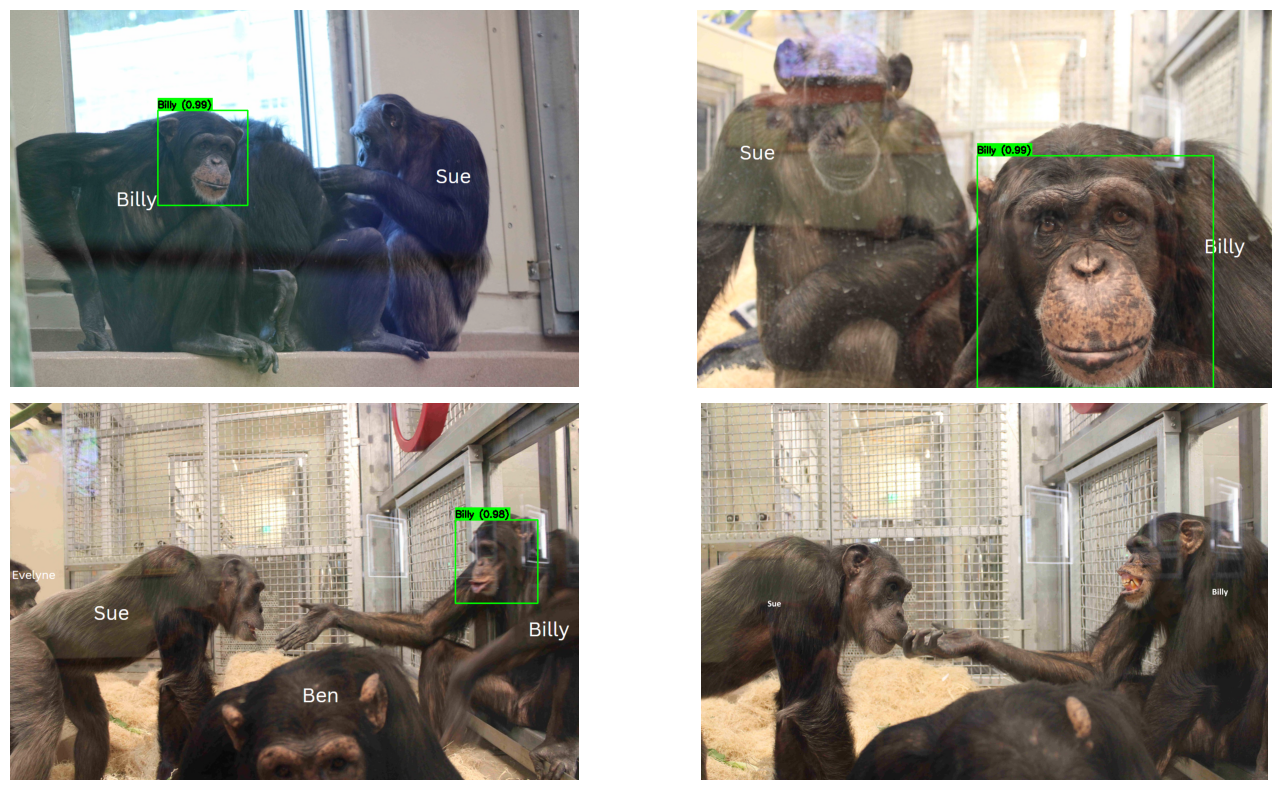

In [10]:
sample_outs = glob.glob(os.path.join(OUTPUT_DIR, '*'))[:4]
plt.figure(figsize=(15, 8))
for i, p in enumerate(sample_outs, 1):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()